In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [ ]:
!ls *.png

bliss.png	    gits1.png  lines.png		    three_xor_stego.png
four_xor_stego.png  gits2.png  parallel_four_xor_stego.png


## Reading the image

In [ ]:
cover_image = cv2.imread('gits1.png')
cover_image = cv2.cvtColor(cover_image, cv2.COLOR_BGR2GRAY)
secret_image = cv2.imread('lines.png')
secret_image = cv2.cvtColor(secret_image, cv2.COLOR_BGR2GRAY)
secret_image[secret_image>0] = 1

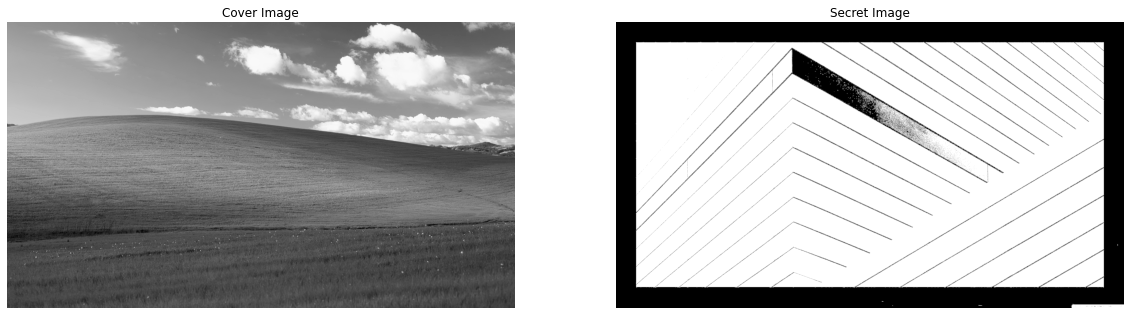

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.title("Cover Image")
plt.axis("off")
plt.imshow(cover_image, cmap="gray")

plt.subplot(122)
plt.title("Secret Image")
plt.axis("off")
plt.imshow(secret_image, cmap="gray")

plt.show()

In [ ]:
print(secret_image.shape)
print(cover_image.shape)

(2160, 3840)
(2160, 3840)


In [ ]:
%%time
cover_flatten = cover_image.flatten()
secret_flatten = secret_image.flatten()
print(cover_flatten.shape)
print(secret_flatten.shape)

(8294400,)
(8294400,)
CPU times: user 1.73 ms, sys: 409 µs, total: 2.14 ms
Wall time: 1.76 ms


## Encoding the image

In [ ]:
cover_flatten

array([148, 148, 149, ...,  54,  51,  51], dtype=uint8)

In [ ]:
def three_xor_encode(c_flatten, s_flatten):
    encoded_flatten = []
    for a, b in zip(c_flatten, s_flatten):
        a = np.binary_repr(a, width=8)
        xor_6_7 = int(a[2]) ^ int(a[1])
        xor_7_8 = xor_6_7 ^ int(a[0])
        xor_hidden = int(b) ^ xor_7_8
        save = a[:-1] + str(xor_hidden)
        encoded_flatten.append(int(save, 2))
    return encoded_flatten

In [ ]:
%%time
three_xor_encoded_flatten = three_xor_encode(cover_flatten, secret_flatten)

CPU times: user 15.3 s, sys: 32.7 ms, total: 15.3 s
Wall time: 15.4 s


In [ ]:
three_xor_stego_image = np.array(three_xor_encoded_flatten)
three_xor_stego_image = np.reshape(three_xor_stego_image, cover_image.shape)

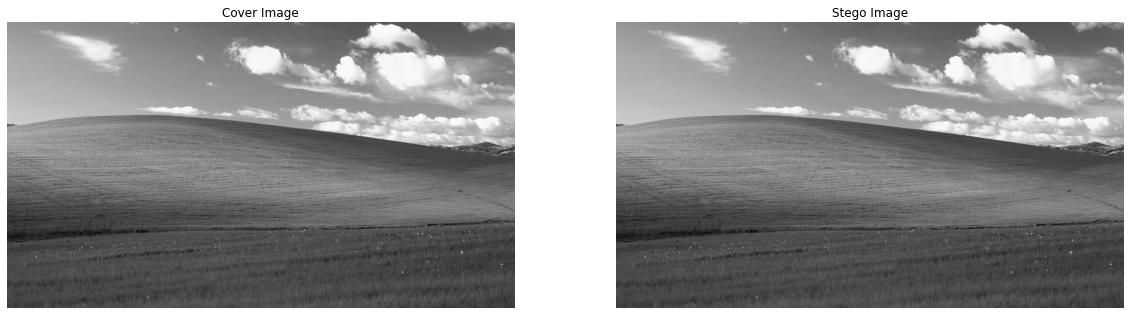

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.title("Cover Image")
plt.axis("off")
plt.imshow(cover_image, cmap="gray")

plt.subplot(122)
plt.title("Stego Image")
plt.axis("off")
plt.imshow(three_xor_stego_image, cmap="gray")

plt.show()

In [ ]:
## Saving the stego image
cv2.imwrite('three_xor_stego.png', three_xor_stego_image)
!ls *.png

bliss.png	    gits1.png  lines.png		    three_xor_stego.png
four_xor_stego.png  gits2.png  parallel_four_xor_stego.png


## Reading & decoding the saved image


In [ ]:
three_xor_stego_image = cv2.imread('three_xor_stego.png', 0)
three_xor_stego_flatten = three_xor_stego_image.flatten()
print(three_xor_stego_flatten.shape)

(8294400,)


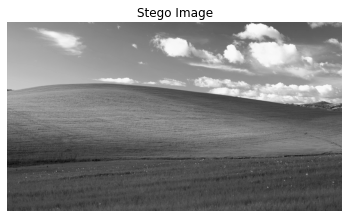

In [ ]:
plt.title("Stego Image")
plt.axis("off")
plt.imshow(three_xor_stego_image, cmap="gray")
plt.show()

In [ ]:
def three_xor_decode(stego_flatten):
    hidden_image = []
    for i in stego_flatten:
        i = np.binary_repr(i, width=8)
        xor_6_7 = int(i[2]) ^ int(i[1])
        xor_7_8 = xor_6_7 ^ int(i[0])
        xor_hidden = int(i[-1]) ^ xor_7_8
        hidden_image.append(int(xor_hidden))
    return hidden_image

In [ ]:
%%time
three_xor_decoded = three_xor_decode(three_xor_stego_flatten)

CPU times: user 11.5 s, sys: 12 ms, total: 11.5 s
Wall time: 11.5 s


(2160, 3840)


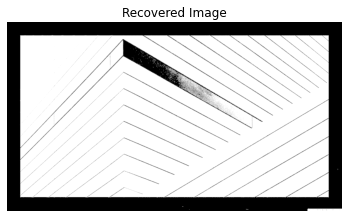

In [ ]:
three_xor_recover_image = np.reshape(np.array(three_xor_decoded), cover_image.shape)
print(three_xor_recover_image.shape)
# three_xor_recover_image[three_xor_recover_image==1] = 255
plt.title("Recovered Image")
plt.axis("off")
plt.imshow(three_xor_recover_image, cmap="gray")
plt.show()

## Histogram Analysis

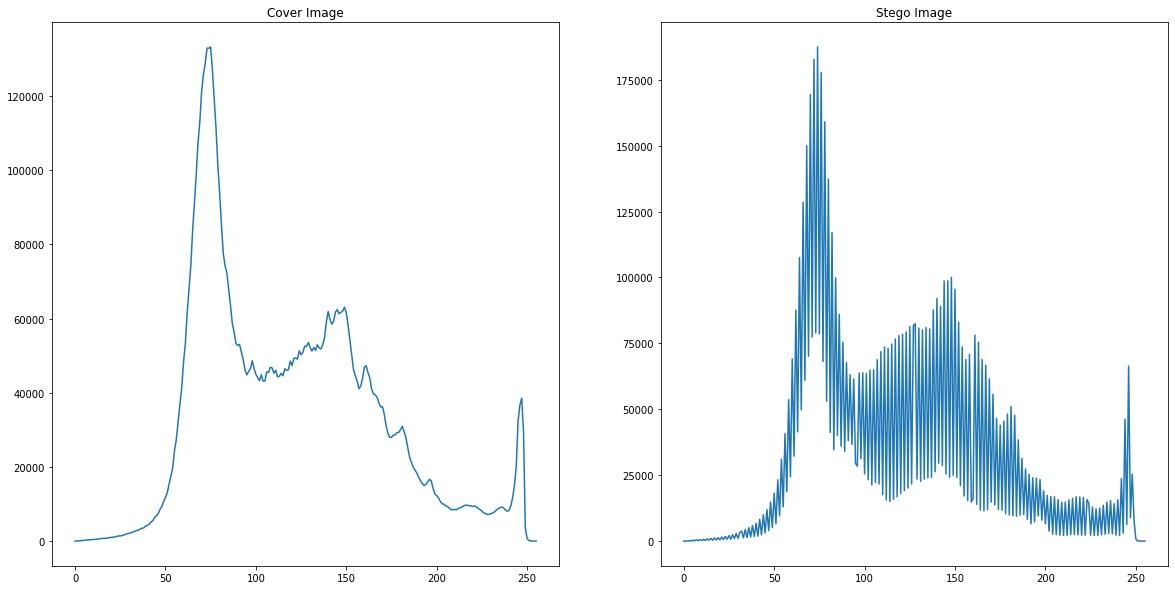

In [ ]:
hist_cover = cv2.calcHist([cover_image], [0], None, [256], [0, 256])
hist_three_xor_stego = cv2.calcHist([three_xor_stego_image], [0], None, [256], [0, 256])

plt.figure(figsize=(20,10))

plt.subplot(121)
plt.title("Cover Image")
plt.plot(hist_cover)

plt.subplot(122)
plt.title("Stego Image")
plt.plot(hist_three_xor_stego)

plt.show()

In [ ]:
methods = (("Correlation", cv2.HISTCMP_CORREL), 
           ("Chi-Squared", cv2.HISTCMP_CHISQR), 
           ("Intersection", cv2.HISTCMP_INTERSECT), 
           ("Hellinger", cv2.HISTCMP_HELLINGER))

for name, method in methods:
    compare = cv2.compareHist(hist_cover, hist_three_xor_stego, method)
    
    ideal = cv2.compareHist(hist_cover, hist_cover, method)
    print("{}: {} ({})".format(name, compare, ideal))
print(f"PSNR SCORE: {cv2.PSNR(cover_image, three_xor_stego_image)}")

Correlation: 0.8085151142996424 (1.0)
Chi-Squared: 2400189.8876157897 (0.0)
Intersection: 6130064.0 (8294400.0)
Hellinger: 0.20231002899443706 (0.0)
PSNR SCORE: 51.1310829656006


## Encoding 4 MSB with XOR


In [ ]:
# def toBinary(num):
#     return '{0:08b}'.format(int(num))

In [ ]:
def four_xor_encode(c_flatten, s_flatten):
    encoded_flatten = []
    for a, b in zip(c_flatten, s_flatten):
        a = np.binary_repr(a, width=8)
#         a = toBinary(a)
        xor_5_6 = int(a[3]) ^ int(a[2])
        xor_6_7 = xor_5_6 ^ int(a[1])
        xor_7_8 = xor_6_7 ^ int(a[0])
        xor_hidden = int(b) ^ xor_7_8
        save = a[:-1] + str(xor_hidden)
        encoded_flatten.append(int(save, 2))
    return encoded_flatten

In [ ]:
%%time
four_xor_encoded_flatten = four_xor_encode(list(cover_flatten), list(secret_flatten))

CPU times: user 15.8 s, sys: 280 ms, total: 16.1 s
Wall time: 16.1 s


In [ ]:
type(four_xor_encoded_flatten)

list

In [ ]:
four_xor_stego_image = np.array(four_xor_encoded_flatten)
four_xor_stego_image = np.reshape(four_xor_stego_image, cover_image.shape)

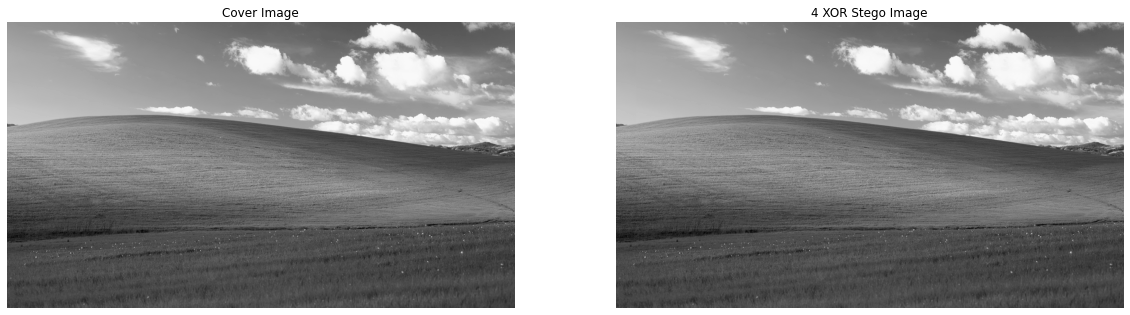

bliss.png	    gits1.png  lines.png		    three_xor_stego.png
four_xor_stego.png  gits2.png  parallel_four_xor_stego.png


In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.title("Cover Image")
plt.axis("off")
plt.imshow(cover_image, cmap="gray")

plt.subplot(122)
plt.title("4 XOR Stego Image")
plt.axis("off")
plt.imshow(four_xor_stego_image, cmap="gray")

plt.show()

## Saving the stego image
cv2.imwrite('four_xor_stego.png', four_xor_stego_image)
!ls *.png

## Decoding the 4 XOR image

(8294400,)


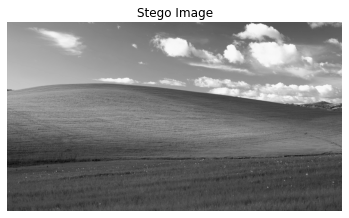

In [ ]:
four_xor_stego_image = cv2.imread('four_xor_stego.png', 0)
four_xor_stego_flatten = four_xor_stego_image.flatten()
print(four_xor_stego_flatten.shape)


plt.title("Stego Image")
plt.axis("off")
plt.imshow(four_xor_stego_image, cmap="gray")
plt.show()

In [ ]:
def four_xor_decode(stego_flatten):
    hidden_image = []
    for i in stego_flatten:
        i = np.binary_repr(i, width=8)
        xor_5_6 = int(i[3]) ^ int(i[2])
        xor_6_7 = xor_5_6 ^ int(i[1])
        xor_7_8 = xor_6_7 ^ int(i[0])
        xor_hidden = int(i[-1]) ^ xor_7_8
        hidden_image.append(int(xor_hidden))
    return hidden_image

In [ ]:
%%time
four_xor_decoded = four_xor_decode(four_xor_stego_flatten)

CPU times: user 12.6 s, sys: 11.7 ms, total: 12.7 s
Wall time: 12.7 s


(2160, 3840)


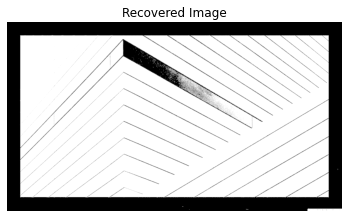

In [ ]:
four_xor_recover_image = np.reshape(np.array(four_xor_decoded), cover_image.shape)
print(four_xor_recover_image.shape)
# four_xor_recover_image[four_xor_recover_image==1] = 255
plt.title("Recovered Image")
plt.axis("off")
plt.imshow(four_xor_recover_image, cmap="gray")
plt.show()

## Histogram Analysis

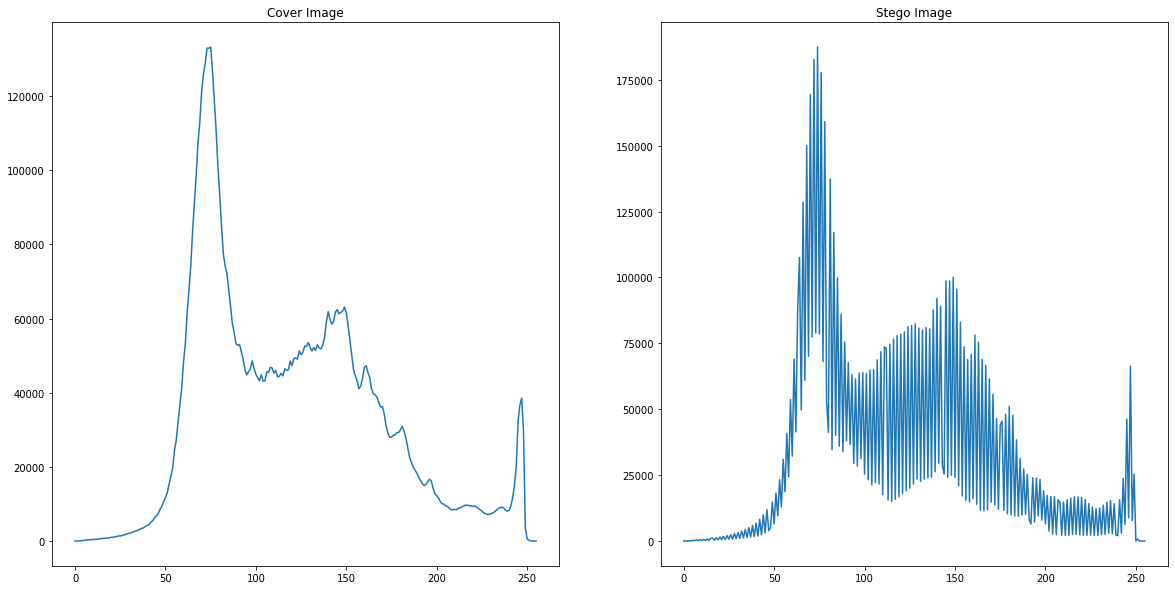

In [ ]:
hist_cover = cv2.calcHist([cover_image], [0], None, [256], [0, 256])
hist_four_xor_stego = cv2.calcHist([four_xor_stego_image], [0], None, [256], [0, 256])

plt.figure(figsize=(20,10))

plt.subplot(121)
plt.title("Cover Image")
plt.plot(hist_cover)

plt.subplot(122)
plt.title("Stego Image")
plt.plot(hist_four_xor_stego)

plt.show()

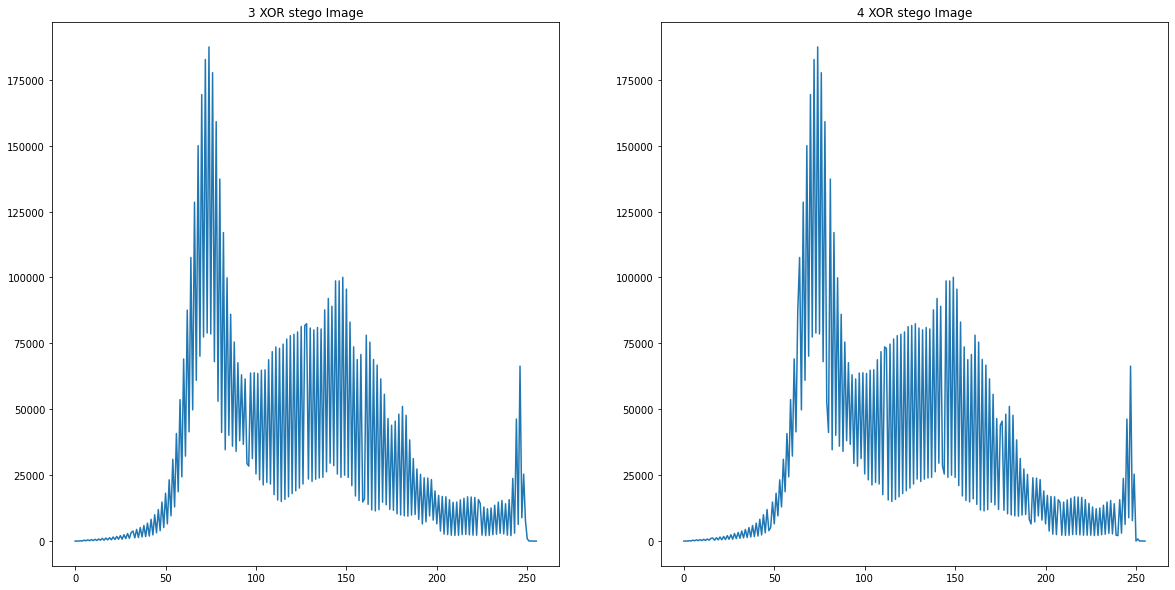

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.title("3 XOR stego Image")
plt.plot(hist_three_xor_stego)

plt.subplot(122)
plt.title("4 XOR stego Image")
plt.plot(hist_four_xor_stego)

plt.show()

In [ ]:
def evaluation_compare(hist_cover, stego_list, cover_image, stego_image_list):
    eval_list = []
    i = 0
    methods = (("Correlation", cv2.HISTCMP_CORREL), 
               ("Chi-Squared", cv2.HISTCMP_CHISQR), 
               ("Intersection", cv2.HISTCMP_INTERSECT), 
               ("Hellinger", cv2.HISTCMP_HELLINGER))
    for x in stego_list:
        x_dict = {}
        for name, method in methods:
            compare = cv2.compareHist(hist_cover, x, method)            
            ideal = cv2.compareHist(hist_cover, hist_cover, method)
#             print("{}: {} ({})".format(name, compare, ideal))
            x_dict[name] = compare
        x_dict['PSNR score'] = cv2.PSNR(cover_image, stego_image_list[i])
        i += 1
        eval_list.append(x_dict)   
    print(f"PSNR SCORE: {cv2.PSNR(cover_image, three_xor_stego_image)}")
    return eval_list

In [ ]:
eval_list = evaluation_compare(hist_cover, 
                              [hist_three_xor_stego, hist_four_xor_stego], 
                              cover_image, 
                              [three_xor_stego_image, four_xor_stego_image])
eval_df = pd.DataFrame(eval_list)
eval_df

PSNR SCORE: 51.1310829656006


,Correlation,Chi-Squared,Intersection,Hellinger,PSNR score
0,0.808515,2.400190e+06,6130064.0,0.202310,51.131083
1,0.804309,2.503745e+06,6128484.0,0.203074,51.133487


## Result

#### Both are roughly similar in metrics but the file size of replacing 4 MSB is closer to the original

## Parallelizing 4 XOR MSB Encode-Decode Steganograpy Algorithm Using Dask

### Parallel Encoding

In [ ]:
from dask.delayed import delayed
from dask.distributed import Client 
from dask.distributed import performance_report
import dask.array as da
import dask

In [ ]:
!lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   39 bits physical, 48 bits virtual
CPU(s):                          8
On-line CPU(s) list:             0-7
Thread(s) per core:              2
Core(s) per socket:              4
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           158
Model name:                      Intel(R) Core(TM) i7-7820HK CPU @ 2.90GHz
Stepping:                        9
CPU MHz:                         2900.000
CPU max MHz:                     3900.0000
CPU min MHz:                     800.0000
BogoMIPS:                        5799.77
Virtualization:                  VT-x
L1d cache:                       128 KiB
L1i cache:                       128 KiB
L2 cache:                        1 MiB
L3 cache:                      

In [ ]:
client = Client(n_workers = 8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 31.23 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41077,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 31.23 GiB
Comm: tcp://127.0.0.1:44517,Total threads: 1
Dashboard: http://127.0.0.1:34337/status,Memory: 3.90 GiB
Nanny: tcp://127.0.0.1:43087,


In [ ]:
# client.close()

In [ ]:
length = len(cover_flatten)
batch_size = int(length / 8)

In [ ]:
%%time
def parallel_encode(c_flatten, s_flatten):
    tasks = []
    for i in range(0, length, batch_size):        
        z = delayed(four_xor_encode)(cover_flatten[i:i+batch_size], secret_flatten[i:i+batch_size])
        tasks.append(z)
    
    model = dask.visualize(*tasks, filename='encode_task_graph.svg')
    with performance_report(filename="encode_dask-report.html"):
        encoded_list = dask.compute(*tasks, scheduler='processes')
    
    return encoded_list

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


In [ ]:
%%time
encoded_list = parallel_encode(cover_flatten, secret_flatten)

CPU times: user 1.63 s, sys: 202 ms, total: 1.83 s
Wall time: 13.7 s


In [ ]:
print(len(encoded_list))
print(type(encoded_list))

8
<class 'tuple'>


In [ ]:
parallel_four_xor_flatten = []
for i in encoded_list:
    parallel_four_xor_flatten.extend(i)
len(parallel_four_xor_flatten)    

8294400

In [ ]:
parallel_four_xor_stego_image = np.array(parallel_four_xor_flatten)
parallel_four_xor_stego_image = np.reshape(parallel_four_xor_stego_image, cover_image.shape)

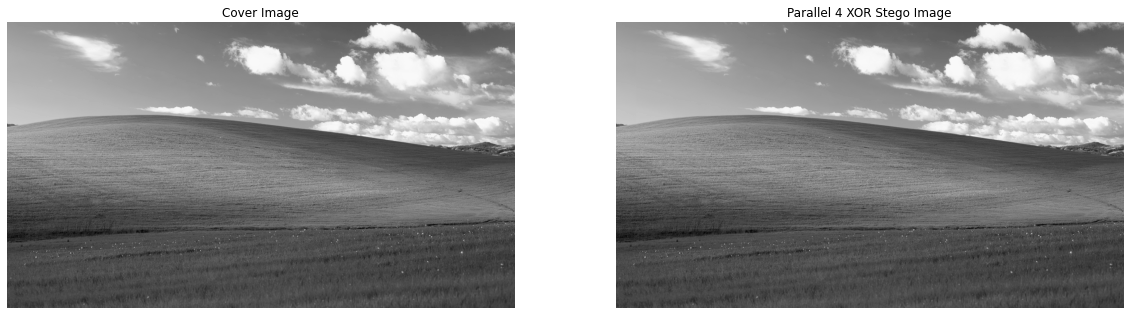

bliss.png	    gits1.png  lines.png		    three_xor_stego.png
four_xor_stego.png  gits2.png  parallel_four_xor_stego.png


In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.title("Cover Image")
plt.axis("off")
plt.imshow(cover_image, cmap="gray")

plt.subplot(122)
plt.title("Parallel 4 XOR Stego Image")
plt.axis("off")
plt.imshow(parallel_four_xor_stego_image, cmap="gray")

plt.show()

## Saving the stego image
cv2.imwrite('parallel_four_xor_stego.png', parallel_four_xor_stego_image)
!ls *.png

### Parallel Decoding

(8294400,)


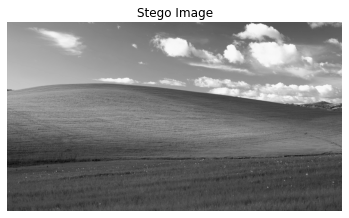

In [ ]:
parallel_four_xor_stego_image = cv2.imread('parallel_four_xor_stego.png', 0)
parallel_four_xor_stego_flatten = parallel_four_xor_stego_image.flatten()
print(parallel_four_xor_stego_flatten.shape)


plt.title("Stego Image")
plt.axis("off")
plt.imshow(parallel_four_xor_stego_image, cmap="gray")
plt.show()

In [ ]:
%%time
def parallel_decode(stego_flatten):
    tasks = []
    for i in range(0, length, batch_size):        
        z = delayed(four_xor_decode)(stego_flatten[i:i+batch_size])
        tasks.append(z)
    
    decoded_model = dask.visualize(*tasks, filename='decode_task_graph.svg')
    with performance_report(filename="decode_dask-report.html"):
        decoded_list = dask.compute(*tasks, scheduler='processes')
    
    return decoded_list

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


In [ ]:
%%time
parallel_four_xor_decoded = parallel_decode(parallel_four_xor_stego_flatten)

CPU times: user 1.18 s, sys: 205 ms, total: 1.39 s
Wall time: 11.5 s


(2160, 3840)


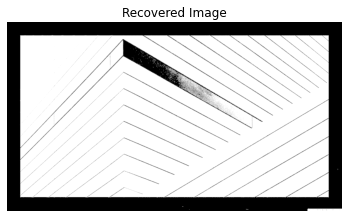

In [ ]:
parallel_four_xor_recover_image = np.reshape(np.array(parallel_four_xor_decoded), cover_image.shape)
print(parallel_four_xor_recover_image.shape)
# parallel_four_xor_recover_image[parallel_four_xor_recover_image==1] = 255
plt.title("Recovered Image")
plt.axis("off")
plt.imshow(parallel_four_xor_recover_image, cmap="gray")
plt.show()

## Histogram Analysis

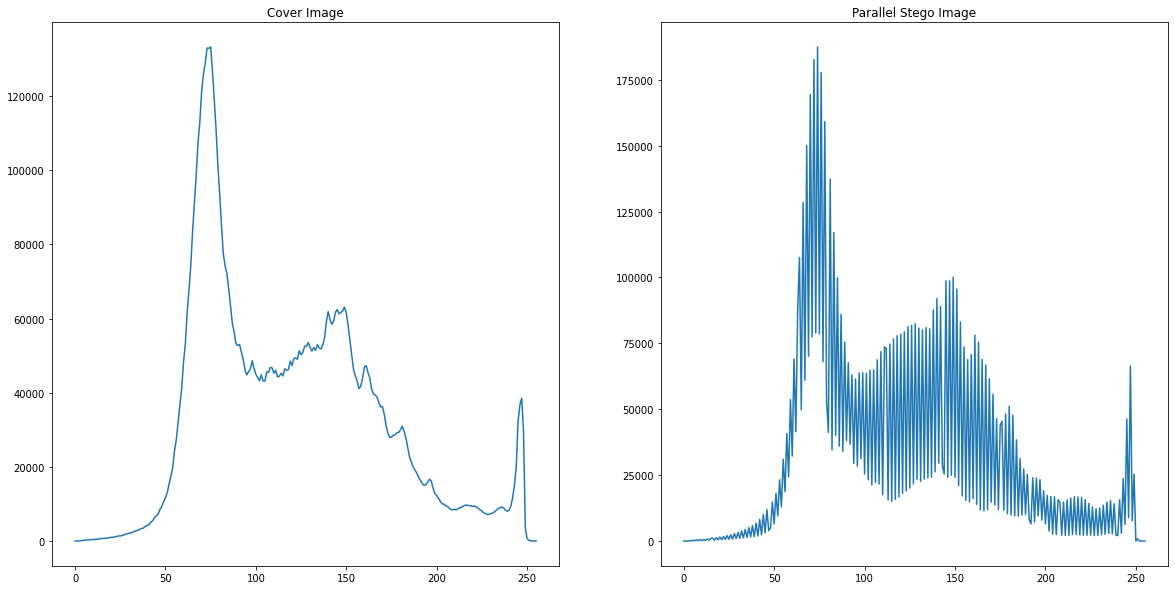

In [ ]:
hist_cover = cv2.calcHist([cover_image], [0], None, [256], [0, 256])
hist_parallel_four_xor_stego = cv2.calcHist([parallel_four_xor_stego_image], [0], None, [256], [0, 256])

plt.figure(figsize=(20,10))

plt.subplot(121)
plt.title("Cover Image")
plt.plot(hist_cover)

plt.subplot(122)
plt.title("Parallel Stego Image")
plt.plot(hist_parallel_four_xor_stego)

plt.show()

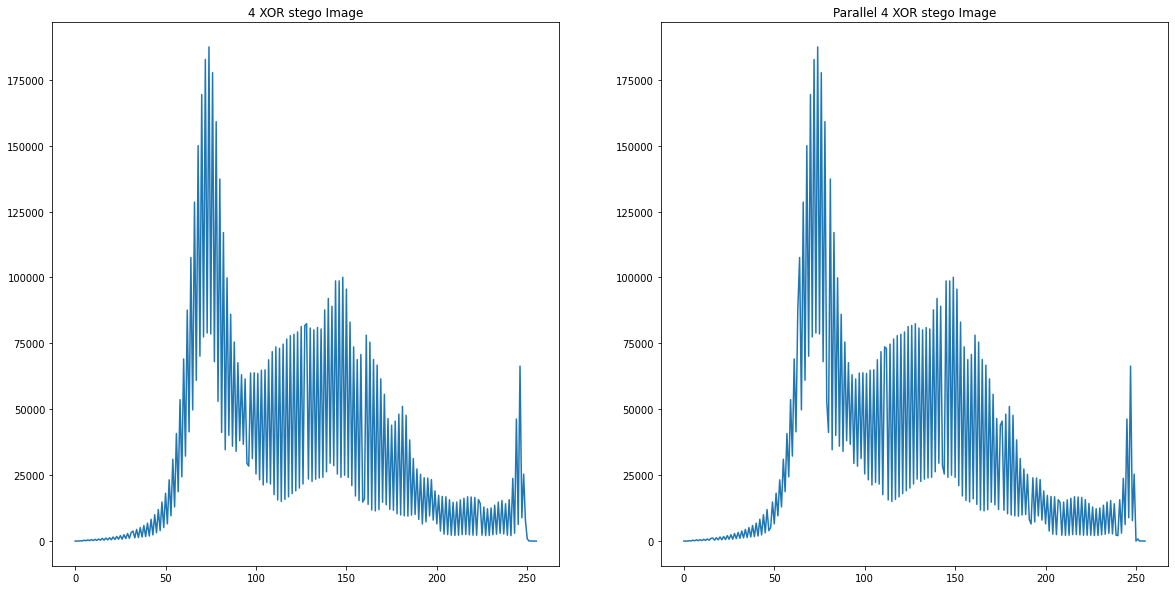

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.title("4 XOR stego Image")
plt.plot(hist_three_xor_stego)

plt.subplot(122)
plt.title("Parallel 4 XOR stego Image")
plt.plot(hist_parallel_four_xor_stego)

plt.show()

In [ ]:
parallel_eval_list = evaluation_compare(hist_cover, 
                              [hist_three_xor_stego, hist_four_xor_stego, hist_parallel_four_xor_stego], 
                              cover_image, 
                              [three_xor_stego_image, four_xor_stego_image, parallel_four_xor_stego_image])
parallel_eval_df = pd.DataFrame(parallel_eval_list)
parallel_eval_df

PSNR SCORE: 51.1310829656006


,Correlation,Chi-Squared,Intersection,Hellinger,PSNR score
0,0.808515,2.400190e+06,6130064.0,0.202310,51.131083
1,0.804309,2.503745e+06,6128484.0,0.203074,51.133487
2,0.804309,2.503745e+06,6128484.0,0.203074,51.133487


## Result

### Parallel Processing Using Dask Has given a speedup without any change in the output